# Exercise 1: Simplified motor

In this exercise you will learn how to set up a simulation of the magnetic field of a simplified motor using the open-source Finite Element library [Nutils]. The motor consists of a single coil and an ellipsoidal, iron rotor. We assume that the magnetic field in the domain of interest does not vary in the direction of rotation, hence the simulation will be essentially 2D. Furthermore, we'll simulate only a single point in time. The following figure shows the 2D domain $X$:

![domain](exercise1.svg)


The grey area, $X_\text{rotor}$, is the rotor. The red area, $X_\text{p}$, is the section of the coil with positive current density in direction $x_2$ (normal to this screen, towards you) and the blue area, $X_\text{n}$ the section with negative current density. The coil consists of $n_\text{turns}$ turns, evenly distributed, such that the current density is constant:

$$ J_i = \delta_{i2} I n_\text{turns} \begin{cases}
    \left( \int_{X_\text{p}} \mathrm dV \right) ^{-1} & \text{on } X_\text{p} \\
    -\left( \int_{X_\text{n}} \mathrm dV \right) ^{-1} & \text{on } X_\text{n} \\
    0 & \text{elsewhere}
\end{cases} $$

The magnetic reluctivity is the reluctivity of vacuum everywhere except in $X_\text{rotor}$ where the reluctivity is a 5000th of vacuum:

$$ \nu = \begin{cases} \nu_0 / 5000 & \text{on } X_\text{rotor} \\ \nu_0 & \text{elsewhere} \end{cases} $$

The objective is to determine the torque applied to the rotor. For this we need to solve the magnetic field in the domain of interest. In 3D the magnetic field is described by

$$ \nabla_j\left(\nu \nabla_j(A_i)\right) = -J_i, $$

where $A$ is the magnetic vector potential, $\nu$ is the piecewise constant reluctivity and $J$ is the current density. The magnetic field density is then given by the curl of $A$, $B_i = \epsilon_{ijk} \nabla_j(A_k)$. We assume that the magnetic field does not vary in $x_2$, $\nabla_2(B_i) = 0$, hence $A_0$ and $A_1$ are zero and the governing equation simplifies to

$$ \nabla_i\left(\nu \nabla_i(A_2)\right) = -J_2. \quad\text{on } X. $$

Given the magnetic vector potential, we can determine the torque by integrating the Maxwell stress tensor over an annulus enclosing the rotor.

[Nutils]: https://nutils.org

## Import modules

We start with importing the Python modules we need in this script: [Nutils] (the Finite Element library), [NumPy] and [Matplotlib] (the scientific plotting library).

[Nutils]: https://nutils.org/
[NumPy]: https://numpy.org/
[Matplotlib]: https://matplotlib.org/

In [1]:
import csgmsh.mesh
from csgmsh.shape import Circle, Ellipse
import numpy
import nutils.export, nutils.function, nutils.mesh
from nutils.expression_v2 import Namespace
from nutils.solver import System
from matplotlib import pyplot
import treelog_notebook

## Define the units

SI units are imported from nutils library, other units, such as the ones for permeability and torque are defined separately

In [69]:
from nutils.SI import CurrentDensity, ElectricCurrent, Force, Length, MagneticFieldStrength, MagneticFluxDensity, Quantity
MagneticPotential = MagneticFluxDensity * Length
Permeability = MagneticFluxDensity / MagneticFieldStrength
Torque = Force * Length

## Define parameters

We define a set of problem specific parameters. The radius of the domain $X$ as `domain_radius`, the stack length as `lstack` and the number of turns of the coil as `nturns`. When changing these parameters the entire script should be run again.

The current flowing through the coil, `I`, is defined as a `nutils.function.Argument`, which allows the value to be changed via the `args` dictionary without rerunning the entire script.

In [3]:
domain_radius = Length('10cm')
lstack = Length('10cm') # stack length
nturns = 100

I = nutils.function.Argument('I', ()) * ElectricCurrent('A')
args = dict(I=10.)

## Define reference values

We define a set of reference values to make quantities dimensionles. This will be used for generating the mesh and the weak form below.

In [4]:
ref_length = domain_radius
ref_area = numpy.pi * domain_radius**2
ref_flux_density = MagneticFluxDensity('T')

## Generate mesh

We use [gmsh] to generate a mesh for domain $X$. The Python library [csgmsh] provides a convenient interface for defining the relevant subdomains, collected in variable `groups`. [gmsh] writes the generated mesh to a file. As [gmsh] doesn't support dimensional quantities, we generate a mesh in dimensionless quantities by dividing all lengths by `ref_length`.

[gmsh]: https://gmsh.info/
[csgmsh]: https://github.com/evalf/csgmsh

In [5]:
R = domain_radius / ref_length
R_inner_torque_probe = .35 * R
height_torque_probe = 0.1 * domain_radius
R_outer_torque_probe = R_inner_torque_probe + height_torque_probe / ref_length
shaft = Circle(radius=.1*R)
groups = dict(
    domain = Circle(radius=R) - shaft,
    p = Circle(radius=.1*R, center=[-.5*R,.3*R]),
    n = Circle(radius=.1*R, center=[ .5*R,.3*R]),
    rotor = Ellipse(width=.6*R, height=.4*R, angle=30) - shaft,
    torque_probe = Circle(radius=R_outer_torque_probe) - Circle(radius=R_inner_torque_probe),
)
csgmsh.mesh.write('exercise1.msh', groups=groups, elemsize=0.1*R, order=2)

## Initialize a namespace

A Nutils [Namespace] is a collection of variables and a parser for expressions using [Einstein notation]. We create an empty namespace here and we will fill the namespace bit by bit in the following sections.

[Namespace]: https://docs.nutils.org/en/stable/nutils/expression_v2/#nutils.expression_v2.Namespace
[Einstein notation]: https://en.wikipedia.org/wiki/Einstein_notation

In [6]:
ns = Namespace()

To understand how the namespace and namespace expressions work, let's write a matrix-vector product (unrelated to the motor problem). We first define a matrix `ns.M` and a vector `ns.b`.

In [7]:
ns.M = numpy.array([[0., 1.], [-1., 0.]])
ns.b = numpy.array([2., 3.])

The matrix-vector product of `M` and `b` written as a namespace expression is `'M_ij b_j'`. The expression can be parsed into a `nutils.function.Array` (similar to a `numpy.array`, but with delayed execution) using `expr @ ns`. The resulting `nutils.function.Array` can be evaluated to a `numpy.array` using `nutils.function.eval()`. Combining everything:

In [8]:
nutils.function.eval('M_ij b_j' @ ns)

array([ 3., -2.])

You can also assign to a namespace using a namespace expression by suffixing the name of the attribute with the remaining indices. For example, let's assign the matrix-vector product to `ns.c`:

In [9]:
ns.c_i = 'M_ij b_j'
nutils.function.eval(ns.c)

array([ 3., -2.])

## Load mesh

We load the mesh generated in the previous step with Nutils. Nutils separates the mesh into a [topology] and a geometry, respectively variables `X` and `ns.x` in the code below. This separation allows the geometry to be variable ([example](https://examples.nutils.org/official-turek/)). The mesh was generated with dimensionless quantities w.r.t. reference `ref_length`. We multiply the geometry with `ref_length` to obtain the geometry with correct dimensions.

[topology]: https://docs.nutils.org/en/stable/nutils/topology/#nutils.topology.Topology

In [10]:
X, ns.x = nutils.mesh.gmsh('exercise1.msh')
ns.x *= ref_length

gmsh > loaded 2d gmsh topology consisting of #848 elements
- volume groups: domain #848, p #7, n #7, rotor #51, torque_probe #55
gmsh > 1307 vertices are not used


We also define the gradient operator `ns.grad`, the jacobians `ns.dS` and `ns.dL` and the normal `ns.n` w.r.t. geometry `ns.x`.

In [11]:
# define ns.grad, ns.dS, ns.dL and ns.n using ns.x
ns.define_for('x', gradient='grad', jacobians=('dS', 'dL'), normal='n')

 And we define the polar coordinates `ns.r` and `ns.phi` and unit vectors `ns.er` and `ns.ephi`.

In [12]:
ns.r = numpy.linalg.norm(ns.x)
ns.phi = numpy.arctan2(ns.x[1] / ref_length, ns.x[0] / ref_length)

ns.er = nutils.function.normalized('grad_i(r)' @ ns)
ns.ephi = nutils.function.normalized('grad_i(phi)' @ ns)

Finally we define `ns.lstack` as the stack length of the motor. This is simply a copy of the variable we have defined earlier, such that we can use `lstack` also in namespace expressions.

In [13]:
ns.lstack = lstack

## Define plot function

We define functions `plot_field(fun, unit, **kwargs)` and `print_scalar(scalar, unit)`. Skip the implementation on first reading.

In [82]:
smpl = X.sample('bezier', 5)
bnd_smpl = X.boundary.sample('bezier', 5)

smpld_x = smpl.eval(ns.x)
bnd_smpld_x = bnd_smpl.eval(ns.x)

def plot_field(v, vunit=None, *, vlabel=None, title=None, clim=None, contours=None, **kwargs):
    xunit = 'cm'
    if isinstance(v, str):
        if vlabel is None:
            vlabel = v
        if title is None:
            title = v
        v = v @ ns
    v = smpl.eval(v, args or {})
    if vunit is not None:
        v /= vunit
    if isinstance(clim, str) and clim == 'symmetric':
        vmax = numpy.max(abs(v))
        clim = -vmax, vmax
    with nutils.export.mplfigure(f'{title}.png') as fig:
        ax = fig.add_subplot(1, 1, 1)
        nutils.export.triplot(ax, bnd_smpld_x / xunit, hull=bnd_smpl.tri)
        im = nutils.export.triplot(
            ax,
            smpld_x / xunit,
            v,
            tri=smpl.tri,
            clim=clim,
            **kwargs)
        if contours is not None:
            if isinstance(contours, str):
                contours = contours @ ns
            if isinstance(contours, Quantity):
                contours = contours.unwrap()
            contours = smpl.eval(contours, args or {})
            x_units = smpld_x / xunit
            ax.tricontour(x_units.T[0], x_units.T[1], smpl.tri, abs(contours), levels = 10, colors = 'w')
            
        ax.set_xlabel(f'$x_0$ [{xunit}]')
        ax.set_ylabel(f'$x_1$ [{xunit}]')
        fig.colorbar(im, label=vlabel if vunit is None else f'{vlabel or ""} [{vunit}]')
        if title is not None:
            fig.suptitle(title)


def print_scalar(expr, unit=None):
    v = nutils.function.eval(expr @ ns, args or {})
    print((f'{expr}: {{:.3{unit}}}' if unit else f'{expr}: {{}}').format(v))

With `plot_field(fun)` we can plot functions (`nutils.function.Array`) on the topology `X`. For example we can define a subdomain marker function `subdomain_marker` where every non-overlapping subdomain gets a unique number and plot the marker on topology `X`.

`X.indicator('subdom')` is a function that evaluates to 1 inside $X_\text{subdom}$ and 0 elsewhere.

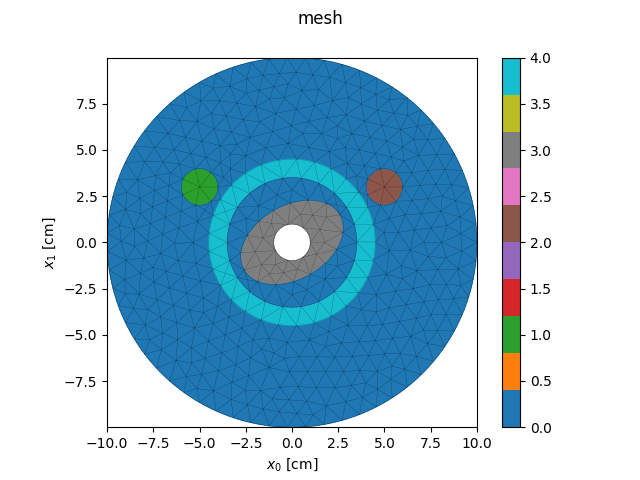

In [15]:
subdomain_marker = 1 * X.indicator('p') + 2 * X.indicator('n') + 3 * X.indicator('rotor') + 4 * X.indicator('torque_probe')
plot_field(subdomain_marker, hull=smpl.hull, cmap='tab10', title='mesh')

The function `print_scalar(expr, unit)` can be used to parse an expression using namespace `ns`, evaluate to a scalar with the current `args` dictionary and print the scalar with the given unit. Example:

In [16]:
print_scalar('lstack', 'cm')

lstack: 10.000cm


## Define knowns

We define the magnetic reluctivity `ns.nu` according to the problem description.

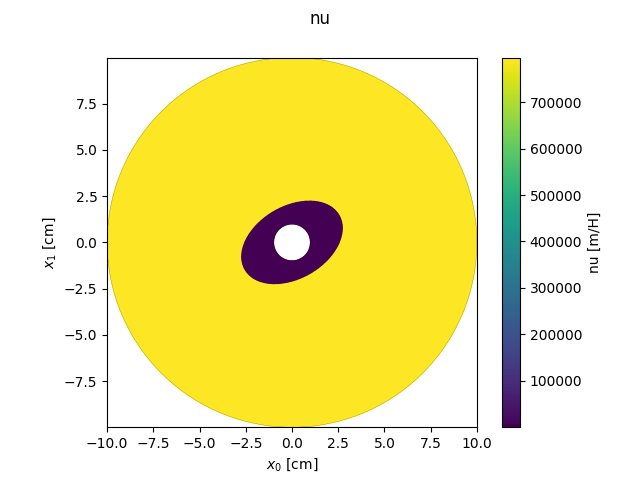

In [17]:
ns.mu0 = 4e-7 * numpy.pi * Permeability('H/m')
ns.nu0 = '1 / mu0'
ns.nu = ns.nu0 * numpy.choose(X.indicator('rotor'), [1, 1/5000])

plot_field('nu', 'm/H')

 We also define the current density `ns.J2`.

`X.indicator('subdom')` is a function that evaluates to 1 inside $X_\text{subdom}$ and 0 elsewhere. `numpy.choose(index, values)` returns `values[index]` for each element of `index`.

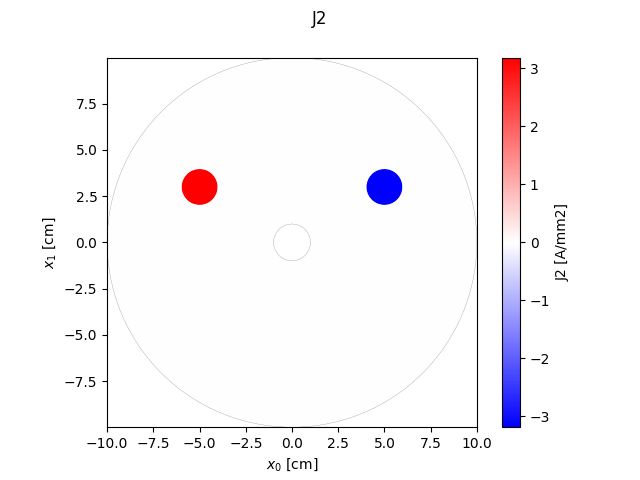

In [18]:
ns.I = I
ns.J2 = (X.indicator('p') - X.indicator('n')) * ns.I * nturns \
    / X['p'].integral('dS' @ ns, degree=1)

plot_field('J2', 'A/mm2', cmap='bwr', clim='symmetric')

## Define weak formulation

The magnetic field is described by the following equation in terms of the magnetic potential $A_2$

$$ \nabla_i\left(\nu \nabla_i(A_2)\right) = -J_2 \quad\text{on } X. $$

with Dirichlet boundary condition

$$ A_2 = 0 \quad\text{at } \partial X. $$

Multiplying the differential equation with a test function $\beta_2$, integrating over $X$ and applying integration by parts to the laplace term gives the weak formulation: Find $A_2$ such that for all $\beta_2$

$$ R := \int_X \left( -\nu \nabla_i(\beta_2) \nabla_i(A_2) + \beta_2 J_2 \right)\ \mathrm dS = 0, $$

subject to $A_2 = 0$ at $\partial X$.

Finally we make the weak formulation discrete by creating a vector of basis functions $f_i$ on $X$ and restricting $A_2$ and $\beta_2$ to a linear combination of basis functions, $A_2 = \hat A_{2i} f_i$ and $\beta_2 = \hat \beta_{2i} f_i$. In the script, `X.field()` does exactly this: return the inner product of a vector of basis functions with a vector of coefficients, a [`nutils.function.Argument`] identified by the name given as first argument to `X.field()`.

We define the residual $R$ as `residual` and make the residual dimensionless by appropriate scaling of `ns.beta2` and dividing the residual by a reference area.

[`nutils.function.Argument`]: https://docs.nutils.org/en/stable/nutils/function/#nutils.function.Argument

In [19]:
ns.A2 = X.field('A2', btype='std', degree=2) * ref_flux_density * ref_length
ns.beta2 = X.field('beta2', btype='std', degree=2) * ns.mu0 * ref_length / ref_flux_density

residual = X.integral('(-nu grad_i(beta2) grad_i(A2) + beta2 J2) dS' @ ns, degree=3) / ref_area

The Dirichlet constraints are obtained by solving the optimization problem

$$ g := \int_{\partial X} A_2^2 \ \mathrm dS = 0 $$

for the subset of $\hat A_{2}$ for which the basis functions $f$ have support on $\partial X$. The constrained coefficients are stored in `constraints`.

In [20]:
g = X.boundary.integral('A2^2 dL' @ ns, degree=5) / (ref_flux_density**2 * ref_length**3)
constraints = System(g, 'A2').solve_constraints(droptol=1e-15)

solve_constraints > optimizing for argument A2 (1766) with drop tolerance 1e-15
solve_constraints > residual norm: 0.0e+00
solve_constraints > optimal value: 0.0e+00
solve_constraints > constrained 140 degrees of freedom of A2


## Solve and plot

With the residual and dirichlet constraints defined, we can solve the discrete problem. The statement `System(residual, trial test).solve(constrain=constraints)` should be read as: For each `test` function find coefficients `trial` such that `residual` vanishes subject to the given Dirichlet `constraints`. Here, `test` and `trial` refer to argument names; the same as given to `X.field()` above. The result of `System.solve()` is a dictionary mapping argument names to the coefficients as `numpy.ndarray`s.

solve > solving for argument A2 (1766) using direct method
solve > residual norm: 2.9e-33


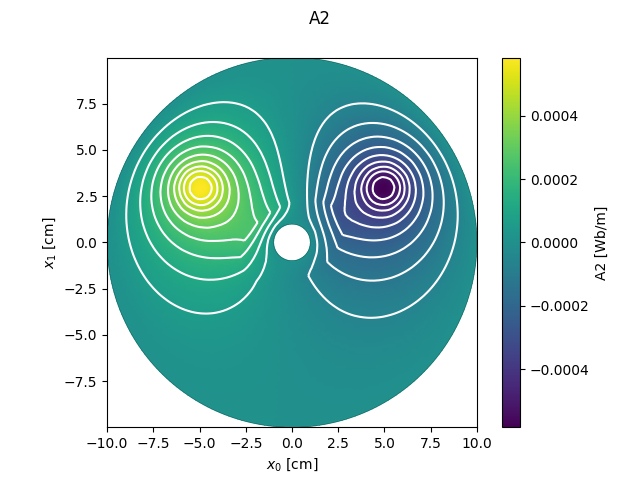

In [83]:
system = System(residual, 'A2', 'beta2')
args = system.solve(constrain=constraints, arguments=args)
plot_field('A2', 'Wb/m', clim='symmetric', contours='A2')

## Exercise 1.1: Plot the $x_0$ and $x_1$ components of the $B$-field

The $B$-field is the curl of the magnetic vector potential $A$. With the Levi-Civita symbol $\epsilon$ the curl can be written concisely as

$$ B_i = \epsilon_{ijk} \nabla_j(A_k). $$

Since we assume that the magnetic field does not vary in $x_2$, we can limit the $B$-field to the first two components:

$$ B_i = \epsilon_{ij2} \nabla_j(A_2) = \epsilon_{ij} \nabla_j(A_2). $$

**Exercise**: Define the $B$-field as `ns.B` by filling in the dots below and run the cell to plot the $B$-field in direction $x_0$ and $x_1$.

**Bonus**: Also plot the radial and angular components of $B$.

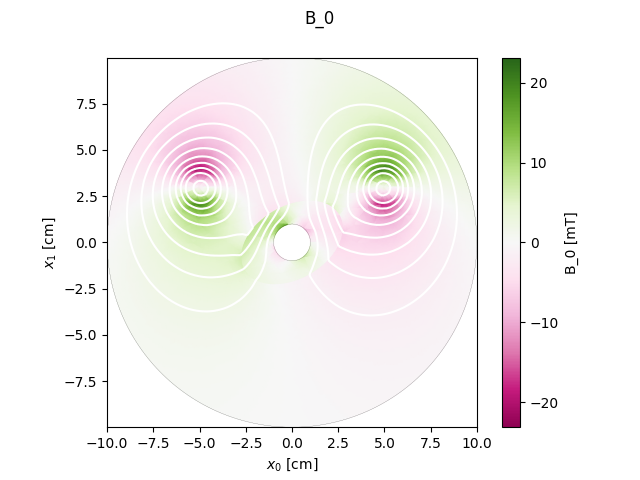

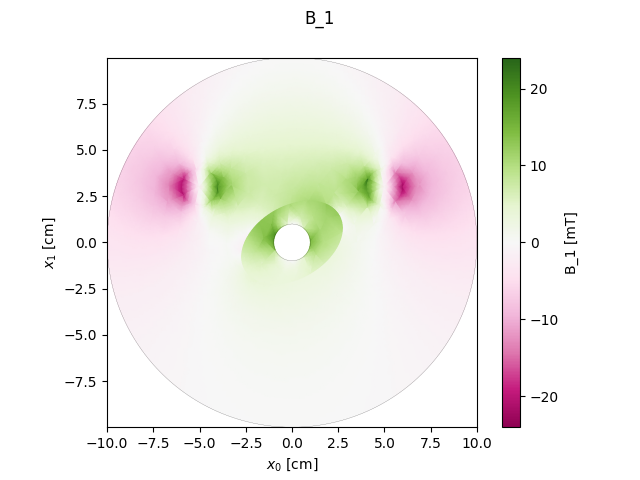

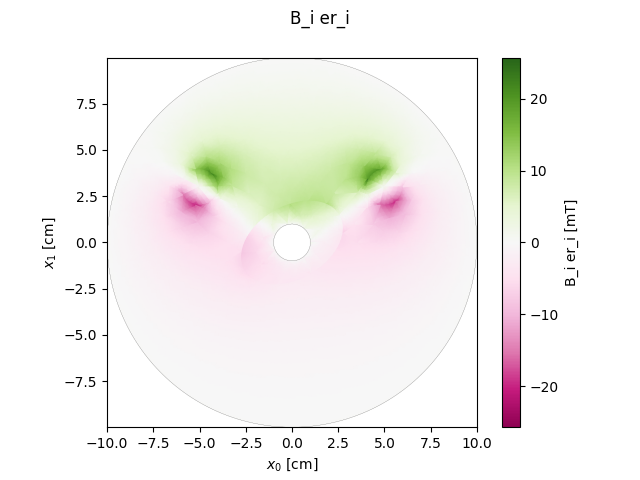

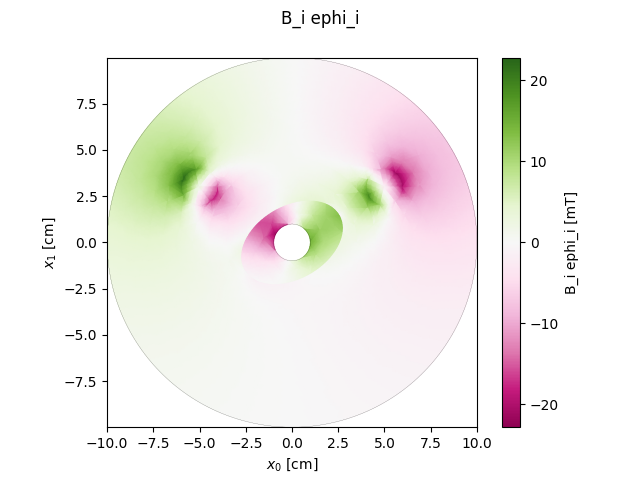

In [41]:
ns.eps = nutils.function.levicivita(2)
ns.B_i = 'eps_ij grad_j(A2)'
plot_field('B_0', 'mT', cmap='PiYG', clim='symmetric', contours = 'A2')
plot_field('B_1', 'mT', cmap='PiYG', clim='symmetric')
# Bonus:
plot_field('B_i er_i', 'mT', cmap='PiYG', clim='symmetric')
plot_field('B_i ephi_i', 'mT', cmap='PiYG', clim='symmetric')

## Exercise 1.2: Compute the flux in the coil

The flux $\Phi$ through a surface $S$ is defined as

$$ \Phi(S) := \int_S B_k n_{Sk} \ \mathrm dS, $$

where $n_{Si}$ is a normal of $S$. Substituting the magnetic vector potential for $B$ gives

$$ \Phi(S) = \int_S \epsilon_{ijk} \nabla_i(A_j) n_{Sk} \ \mathrm dS. $$

By [Stokes' theorem] we can write the surface integral as a contour integral:

$$ \Phi(S) = \oint_{\partial S} \epsilon_{ijk} n_{\partial Si} A_j n_{Sk} \ \mathrm dL, $$

where $n_{\partial Si}$ is the normal of the boundary of $S$.

The objective is to compute the flux through the coil, $S_\text{coil}$ with $n_{S_\text{coil}}$ pointing in the direction of $x_1$. Since we assume that the magnetic field does not vary in $x_2$ we can simplify the contour integral to

$$ \Phi(S_\text{coil}) = l_\text{stack} \left( \left. A_2 \right|_{x=c_p} - \left. A_2 \right|_{x=c_n} \right), $$

where $c_p$ is the center of the positive side of the coil, $c_n$ is the center of the negative side of the coil and $l_\text{stack}$ is the stack length. Out of convenience we approximate $\left. A_2 \right|_{x_p}$ with an average of $A_2$ over the entire positive side of the coil, $X_p$, and similarly for $\left. A_2 \right|_{x_n}$:

$$ \Phi(S_\text{coil}) \approx l_\text{stack} \left( \frac{\int_{X_p} A_2 \ \mathrm dS}{\int_{X_p} \mathrm dV} - \frac{\int_{X_n} A_2 \ \mathrm dV}{\int_{X_n} \ \mathrm dS} \right). $$

**Exercise**: Define the flux through the coil in direction $x_1$ as `ns.flux` by filling in the dots and run the cell to print the flux.

The integral over subdomain $X_\text{p}$ is written as

```
X['p'].integral('... dS' @ ns, degree=3)
```

where `degree` should be chosen appropriately. The stack length $l_\text{stack}$ is available as `lstack`.

[Stokes' theorem]: https://en.wikipedia.org/wiki/Stokes%27_theorem

In [42]:
# Solution:
ns.flux = ns.lstack * (
    X['p'].integral('A2 dS' @ ns, degree=3) / X['p'].integral('dS' @ ns, degree=3)
    - X['n'].integral('A2 dS' @ ns, degree=3) / X['n'].integral('dS' @ ns, degree=3)
)
print_scalar('flux', 'mWb')

flux: 0.083mWb


## Exercise 1.3: Compute the torque applied to the rotor

The torque applied to the rotor can be computed via Arkkio's method by integrating the Maxwell stress tensor over an annulus enclosing the rotor:

$$ \tau_\text{rotor} = \frac{l_\text{stack}}{\Delta r} \int_{X_\text{torque probe}} \nu B_i e_{ri} B_j e_{\phi j} r \ \mathrm dS, $$

where $e_{ri}$ is the unit vector in direction $r$ and $e_{\phi i}$ is the unit vector in direction $\phi$.

**Exercise**: Define the torque applied to the rotor as `ns.torque` by applying Arkkio's method on subdomain `X['torque_probe']` and run the cell to print the torque.

The height of the annulus $\Delta r$ is available as `height_torque_probe` (dimension: length), the vector $e_{r}$ as `'er_i'` (index `i` can be replaced with any latin character) in a namespace expression and the vector $e_{\phi}$ as `'ephi_j'`.

In [43]:
ns.torque = X['torque_probe'].integral('nu B_i er_i B_j ephi_j r dS' @ ns, degree=6) \
    * lstack / height_torque_probe
print_scalar('torque', 'mN*m')

torque: 0.633mN*m


## Exercise 1.4: Find the required current for a specific torque

**Exercise**: Find the current such that the torque applied to the rotor is `1mN*m` by repeatedly changing the value of `args['I']` in the cell below and running the cell.

In [85]:
args['I'] = 12.2 # unit: A
args = system.solve(constrain=constraints, arguments=args)
print_scalar('torque', 'mN*m')

solve > solving for argument A2 (1766) using direct method
solve > residual norm: 8.7e-20
torque: 0.942mN*m


## Use minimize to find the required current for a specific torque

We can write the above exercise as a minimization problem: find the $I$ that minimizes the scalar $f := (\tau - \tau_\text{desired})^2$. We solve this problem by using Newton on the derivative of the $f$ to $I$. We don't have to do this by hand, because Nutils can compute (symbolic) derivatives of `nutils.function.Array`s. The companion script `nutils_solver_extra` contains an implementation:

In [68]:
from nutils_solver_extra import minimize
args = minimize(
    # the scalar to minimize
    ((ns.torque - Torque('1mN*m')) / 'mN*m')**2,
    # the argument(s) to minimize for
    'I',
    # the residual of the weak form
    # required to evaluate the quantity to minimize
    residual,
    # the test function(s) of the weak form
    'A2',
    # the trial function(s) of the weak form
    'beta2',
    # the constraints of the weak form
    constrain=constraints,
    # stop minimizing when the norm of the gradient
    # of the scalar to minimize and the residual
    # are below tol
    tol=1e-8,
    # the starting point of the minimization
    arguments=args,
)
print_scalar('I', 'A')

minimize > minimizing for I () via A2 (1766,)
minimize > iter 0 > scalar = 4.929e-09, norm([grad(scalar), residual]) = 2.234e-05
minimize > iter 1 > scalar = 1.367e-17, norm([grad(scalar), residual]) = 1.176e-09
I: 12.570A
